<a href="https://colab.research.google.com/github/enicole0164/EE488_assignment1/blob/main/EE488_HW1_1_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EE488 HW #1: Classification of MNIST Dataset
====

## Instruction
- In this HW assignment, we design a MNIST classifier using convolutional neural network
- Complete the code by implementing the architecture described in "CNN Architecture" section.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as vision_dsets
import torchvision.transforms as T
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data
import matplotlib.pyplot as plt

## Initilaize Data Loader

In [ ]:
root='./data'
batch_size=32
# Use Mnist data for training

mnist_train = vision_dsets.MNIST(root = root,
                                train = True,
                                transform = T.ToTensor(),
                                download = True)
mnist_test = vision_dsets.MNIST(root = root,
                                train = False,
                                transform = T.ToTensor(),
                                download = True)

trainDataLoader = data.DataLoader(dataset = mnist_train,
                                    batch_size = batch_size,
                                    shuffle =True,
                                    num_workers = 1)

testDataLoader = data.DataLoader(dataset = mnist_test,
                                batch_size = batch_size,
                                shuffle = False,
                                num_workers = 1)


## Define Trainer

In [ ]:
class Trainer():
    def __init__(self, trainloader, testloader, net, optimizer, criterion):

        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer
        self.criterion = criterion

    def train(self, epoch = 1, log_freq = 500):
        self.net.train()
        for e in range(epoch):
            running_loss = 0.0
            for i, (inputs, labels) in enumerate(self.trainloader, 0):
                inputs = inputs.cuda()
                labels = labels.cuda()
                self.optimizer.zero_grad()

                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                if (i+1) % log_freq == 0:
                    print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / log_freq))
                    running_loss = 0.0

        print('Finished Training')

    def test(self):
        self.net.eval()

        test_loss = 0
        correct = 0
        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            output = self.net(inputs)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()

            test_loss /= len(self.testloader.dataset)
        print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.
                format(correct, len(self.testloader.dataset),
                100.* correct / len(self.testloader.dataset)))

# CNN Architecture
Complete this section to implenent a classifier with 3 CNN layers and 2 FCN layers.

Details of architecture are provided in comments below:

In [ ]:
## Fill in the empty space
# Architecture: 3-layers of CNN, 2-layers of FCN
# Layer 1: convolutional layer + batch norm 2d + relu activation
#          output channels: 32, kernel size: (2,2), stride: (2,2)
# Layer 2: convolutional layer + batch norm 2d + relu activation
#          output channels: 64, kernel size: (2,2), stride: (2,2)
# Layer 3: convolutional layer + batch norm 2d + relu activation
#          output channels: 128, kernel size: (2,2), stride: (2,2)
# Layer 4: fully connected layer
#          input: flattened 1d vector from Layer 3 output, output channels: 512
# Layer 5: fully connected layer: output channels 10 (=number of classes)

class MNIST_Net(nn.Module):
    def __init__(self, hidden1, hidden2, hidden3):
        super(MNIST_Net, self).__init__()

        # Convolution Layer 1: Input (1, 28, 28) -> Output (hidden1, 14, 14)
        self.conv0 = nn.Conv2d(1, hidden1, 2, stride=2)
        self.bn0 = nn.BatchNorm2d(hidden1)

        # Convolution Layer 2: Input (hidden1, 14, 14) -> Output (hidden2, 7, 7)
        self.conv1 = nn.Conv2d(hidden1, hidden2, 2, stride=2)
        self.bn1 = nn.BatchNorm2d(hidden2)

        # Convolution Layer 3: Input (hidden2, 7, 7) -> Output (hidden3, 3, 3)
        self.conv2 = nn.Conv2d(hidden2, hidden3, 2, stride=2)
        self.bn2 = nn.BatchNorm2d(hidden3)

        # Fully Connected Layer 3: Input (hidden3 * 3 * 3) -> Output (512)
        self.fc0 = nn.Linear(hidden3 * 3 * 3, 512)

        # Fully Connected Layer 3: Input (512) -> Output (10)
        self.fc1 = nn.Linear(512, 10)


    def forward(self, x):
        # Forward pass through first convolutional layer
        x = self.conv0(x)
        x = self.bn0(x)
        x = F.relu(x) # relu activation

        # Forward pass through second convolutional layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x) # relu activation

        # Forward pass through third convolutional layer
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x) # relu activation

        # Flatten the feature map to a 1D vector for FCL
        x = x.view(x.size(0), -1) # Reshape to [batch_size: 32, features: hidden3 * 3 * 3]

        # Forward pass through first FCL
        x = self.fc0(x)

        # Forward pass through output layer
        x = self.fc1(x)

        return x

In [ ]:
mnist_net = MNIST_Net(hidden1= 32, hidden2 = 64, hidden3 = 128).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

In [ ]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 1)

[1,   500] loss: 0.280
[1,  1000] loss: 0.160
[1,  1500] loss: 0.125
Finished Training


In [ ]:
trainer.test()


Test set:  Accuracy: 9671/10000 (97%)



# Plotting
Below code plots figure of the original input image and predicted probability for each class.

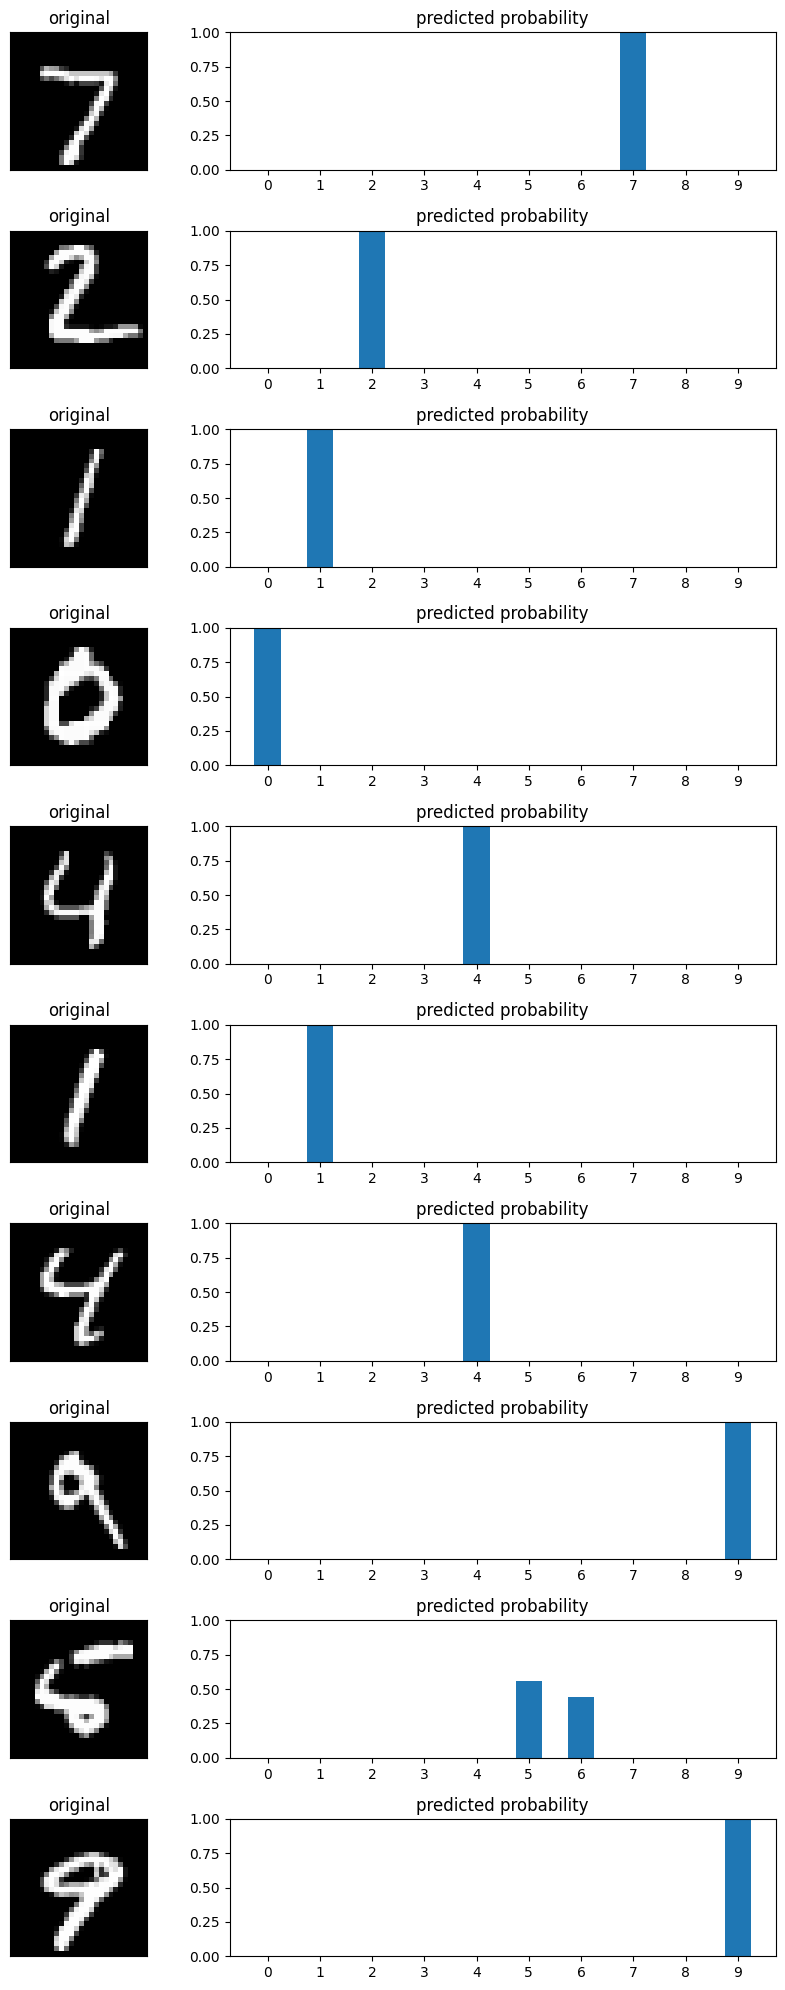

In [ ]:
n = 10 # the number of data to be plotted
plt.figure(figsize=(10, 20)) # total figure size

for i in range(n):
    input_image = mnist_test[i][0].cuda() # (1,28,28) tensor
    input_ = input_image.unsqueeze(0)     # change to (1,1,28,28)
    pred_prob = torch.softmax(mnist_net(input_),dim=1).cpu().detach().squeeze().numpy()

    ax = plt.subplot(n, 2, 2*i+1)
    plt.imshow(input_image[0].cpu()) # show input image
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax2 = plt.subplot(n, 2, 2*i+2)
    ax2.set_ylim([0,1])

    classify_as = [str(i) for i in range(n)]
    plt.bar(classify_as, pred_prob, width = 0.5, tick_label = classify_as) # print predicted probability for each class

    plt.title('predicted probability')
    plt.tight_layout()

plt.show()